End-to-end ML pipeline with exploratory data analysis.

In [1]:
!pip install pandas seaborn scikit-learn matplotlib

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.compose import ColumnTransformer, make_column_selector as selector 
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score 

In [3]:
diamonds = sns.load_dataset('diamonds') 
#basic sanity check 
diamonds.head() 
diamonds.info()
diamonds.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940,53940,53940,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
unique,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,21551,11292,13065,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.797940,NaN,NaN,NaN,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,NaN,NaN,NaN,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,NaN,NaN,NaN,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,NaN,NaN,NaN,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,NaN,NaN,NaN,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000


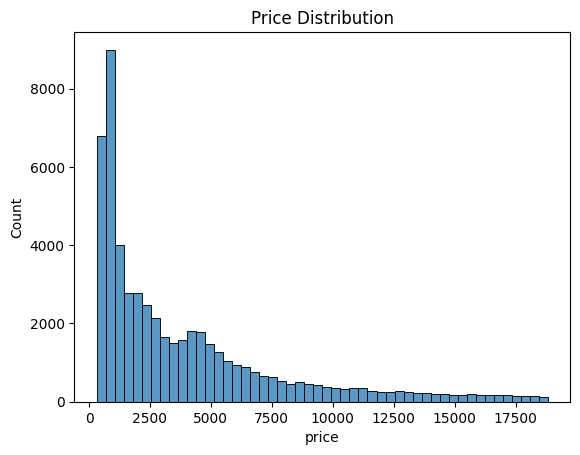

In [4]:
#target distribution 
sns.histplot(diamonds['price'], bins=50)
plt.title('Price Distribution')
plt.show()

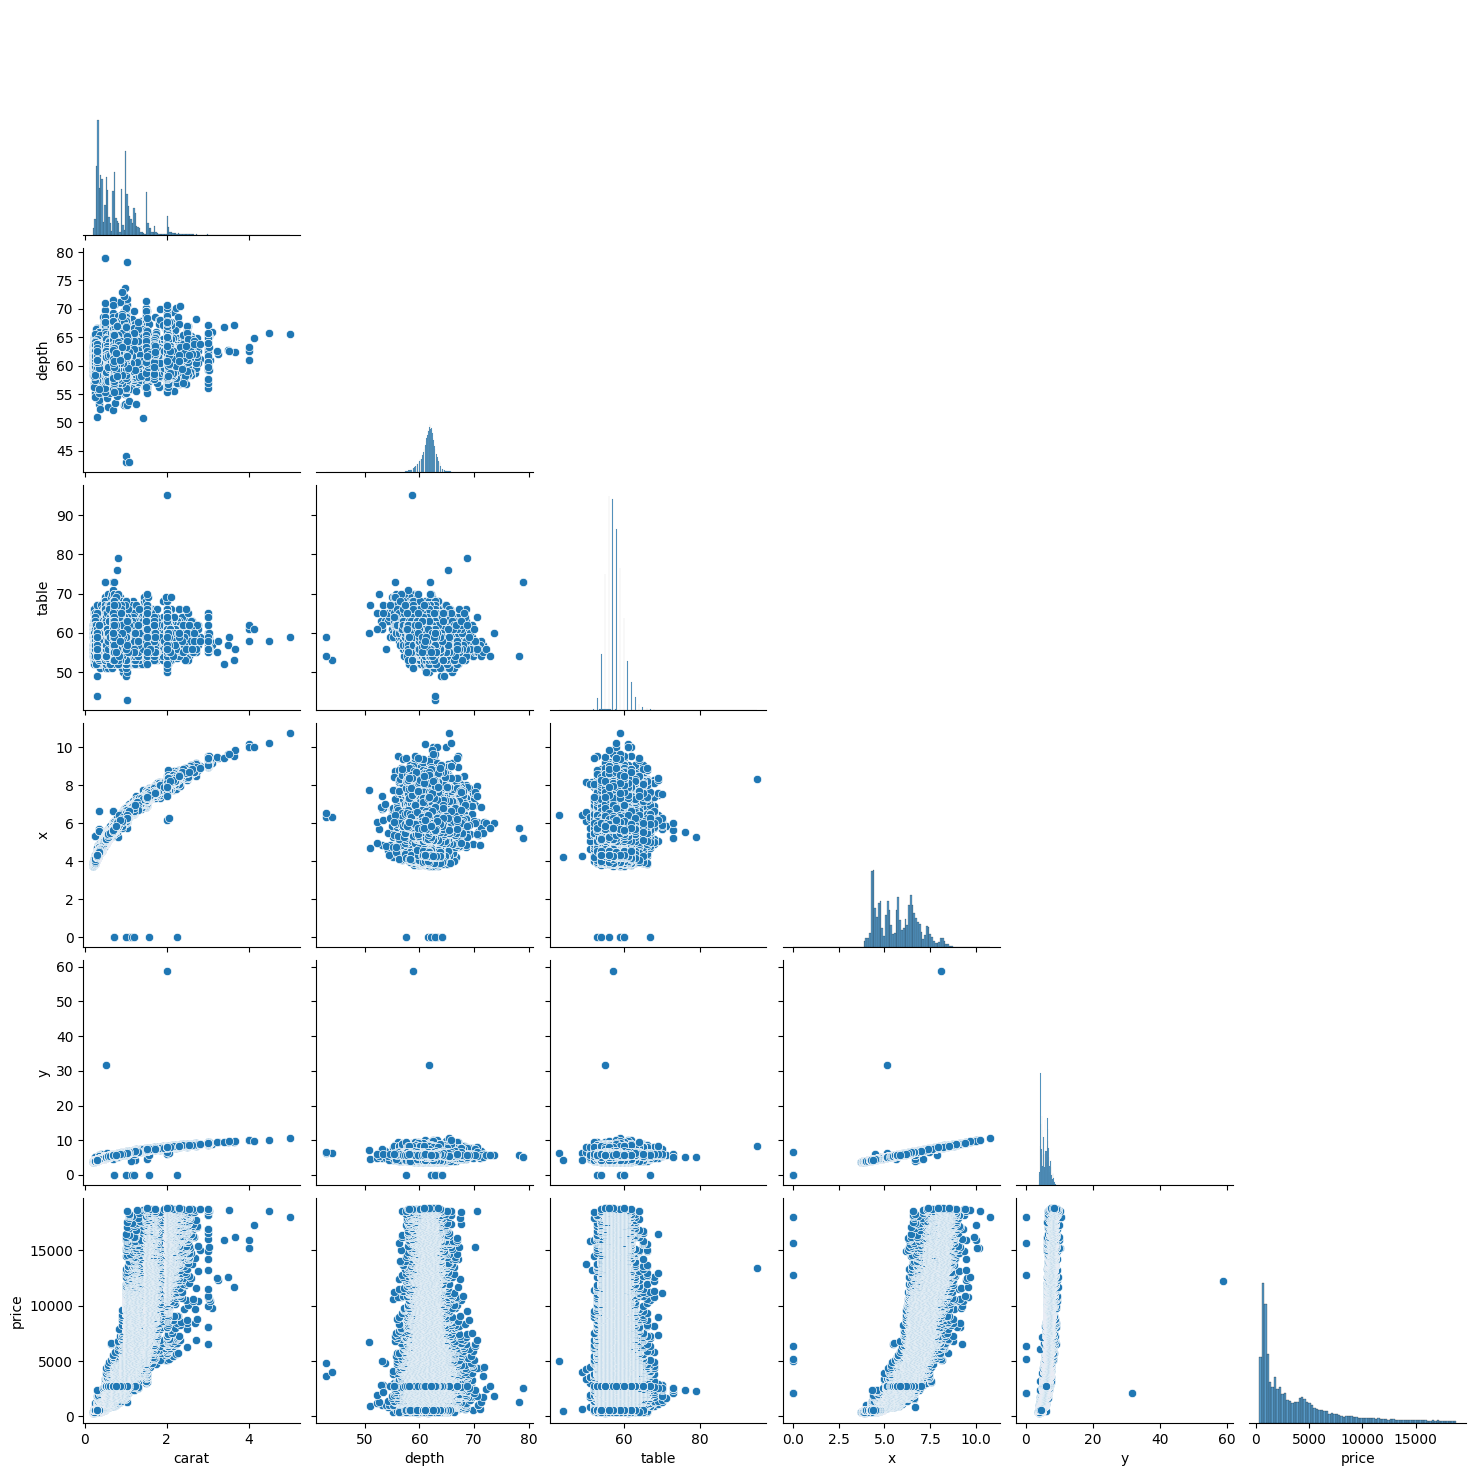

In [5]:
#numeric features vs target 
num_cols = diamonds.select_dtypes(include=np.number).columns.to_list()
sns.pairplot(diamonds, vars=[c for c in num_cols if c!="price"][:5]+['price'], corner=True)
plt.show() 

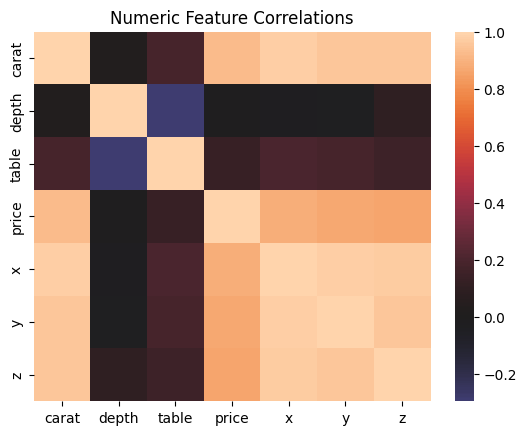

In [6]:
#correlation heatmap(numeric only)
corr = diamonds[num_cols].corr(numeric_only=True)
sns.heatmap(corr, annot=False, center=0)
plt.title("Numeric Feature Correlations"); plt.show()

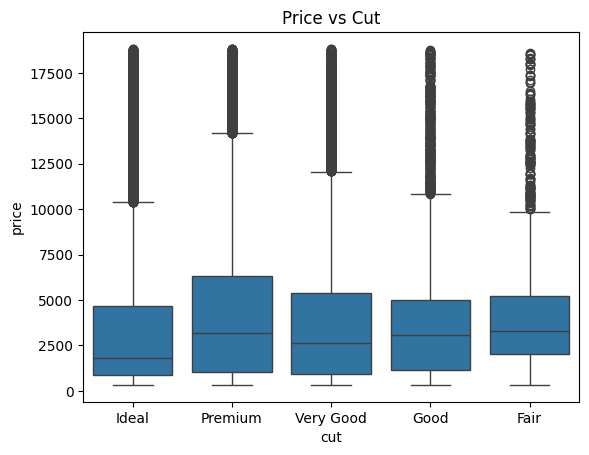

In [7]:
# Categorical feature impact (example: cut)
sns.boxplot(data=diamonds, x="cut", y="price")
plt.title("Price vs Cut"); plt.show()

In [8]:
#split features/target 
X = diamonds.drop(columns=['price'])
y = diamonds['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=None)

In [10]:
#columns selectors 
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_exclude=np.number)

numeric_pipe = Pipeline(
    [
       ("imputer", SimpleImputer(strategy='median')),
       ('scaler', StandardScaler()) ,
    ]
)

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_sel),
    ("cat", categorical_pipe, cat_sel)
])

In [11]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None, 
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('model', model)
])

In [12]:
#train+evaluate 
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print(f"Holdout RMSE: {rmse:,.2f}")
print(f"Holdout R²  : {r2:,.4f}")

Holdout RMSE: 550.46
Holdout R²  : 0.9809


In [13]:
#cross validation 
cv_r2 = cross_val_score(pipe, X,y, cv=5, scoring="r2")
print("CV R² (mean ± std):", f"{cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


CV R² (mean ± std): 0.3058 ± 0.3627


In [14]:
# RMSE (version-proof way)
cv_neg_mse = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_squared_error")
cv_rmse = np.sqrt(-cv_neg_mse)
print("CV RMSE (mean ± std):", f"{cv_rmse.mean():,.2f} ± {cv_rmse.std():,.2f}")

CV RMSE (mean ± std): 1,379.38 ± 1,249.70


In [15]:
# Simple Hyperparameter Search 
from sklearn.model_selection import GridSearchCV 

param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
}

gs = GridSearchCV(
    pipe, param_grid=param_grid, cv=3,
    scoring="neg_mean_squared_error", n_jobs=-1
)

gs.fit(X_train, y_train)
best_pipe = gs.best_estimator_ 
print("Best params:", gs.best_params_)

pred_gs = best_pipe.predict(X_test)
print("Tuned RMSE:", np.sqrt(mean_squared_error(y_test, pred_gs)))
print("Tuned R²  :", r2_score(y_test, pred_gs))

Best params: {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Tuned RMSE: 547.6847583209286
Tuned R²  : 0.9811309074951404


In [18]:
# --- After you've trained best_pipe or rf_pipe and computed permutation_importance as r ---
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

est = best_pipe if 'best_pipe' in globals() else pipe

# Compute permutation importance
r = permutation_importance(est, X_test, y_test, n_repeats=10,
                           random_state=42, n_jobs=-1)

# Robust feature-name extraction
def get_output_feature_names(prep):
    # 1) Best: ask the preprocessor directly (sklearn >= 1.0)
    try:
        return prep.get_feature_names_out()
    except Exception:
        pass
    # 2) Fallback: build from numeric + OHE names
    num_cols = list(prep.transformers_[0][2])  # numeric selected columns
    cat_cols = list(prep.transformers_[1][2])  # categorical selected columns
    ohe = prep.named_transformers_["cat"].named_steps["onehot"]
    try:
        ohe_names = list(ohe.get_feature_names_out(cat_cols))
    except Exception:
        # older sklearn
        ohe_names = list(ohe.get_feature_names(cat_cols))
    return np.array(num_cols + ohe_names, dtype=object)

prep = est.named_steps["prep"]
feat_names = np.asarray(get_output_feature_names(prep))

# --- Guard: align lengths (prevents "All arrays must be of the same length") ---
n_model_feats = r.importances_mean.shape[0]
if feat_names.shape[0] != n_model_feats:
    # Trim or pad names to match (trimming is safest)
    feat_names = feat_names[:n_model_feats]

imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

print(imp_df.head(15))


          feature  importance
0      num__carat    1.226451
7   cat__cut_Good    0.236018
3          num__x    0.150875
2      num__table    0.089829
6   cat__cut_Fair    0.007523
8  cat__cut_Ideal    0.007290
1      num__depth    0.001067
5          num__z    0.000481
4          num__y    0.000420
